<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_6_Transfer_Learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working models existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own. 
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
!nvidia-smi

Fri Jul 16 11:28:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming on with the data

In [2]:
#Get the data (10% of 10 food classes from Food101)

import zipfile
#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-16 11:28:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   146MB/s    in 1.1s    

2021-07-16 11:28:05 (146 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
#How many images in each folder?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"Ther are {len (dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Ther are 2 directories and 0 images in '10_food_classes_10_percent'.
Ther are 10 directories and 0 images in '10_food_classes_10_percent/test'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'

## Creating data loaders (preparing the data)

We´ll use the ImageDataGenerator class to load in our image in batches

In [4]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you cab add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training with the EarlyStoppingCallback

In [5]:
#Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##Creating models using TensorFlow Hub

We can acess pretrained models on https://tfhub.dev/

model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
#Let´s compare the following two models
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [7]:
# Import dependecies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [9]:
#Let´s make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  #Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE + (3,))
  #Create our model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating ResNet TensorFlow Hub Feature Extraction model

In [10]:
#Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
#Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [16]:
#Let´s fir our resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data, callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210716-113405
Epoch 1/5
24/24 [==============================] - 52s 810ms/step - loss: 1.8742 - accuracy: 0.3640 - val_loss: 1.1574 - val_accuracy: 0.6204
Epoch 2/5
24/24 [==============================] - 16s 667ms/step - loss: 0.9077 - accuracy: 0.7333 - val_loss: 0.8688 - val_accuracy: 0.7248
Epoch 3/5
24/24 [==============================] - 15s 662ms/step - loss: 0.6459 - accuracy: 0.8227 - val_loss: 0.7578 - val_accuracy: 0.7512
Epoch 4/5
24/24 [==============================] - 15s 658ms/step - loss: 0.4870 - accuracy: 0.8693 - val_loss: 0.7137 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 15s 663ms/step - loss: 0.3930 - accuracy: 0.9027 - val_loss: 0.6705 - val_accuracy: 0.7840


In [21]:
#Let´s create a function to plot our loss curves
import matplotlib.pyplot as plt

#Plot the validation and training curves
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.
  Returns:
    Plots of training/validation loss accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label=("val_loss"))
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

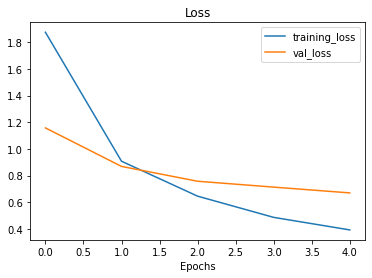

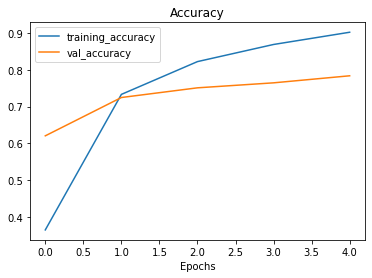

In [22]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFLow Hub Feature Extraction model

In [24]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(efficientnet_url, train_data_10_percent.num_classes)

#Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

#Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data, validation_steps=len(test_data), 
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210716-115944
Epoch 1/5
24/24 [==============================] - 25s 770ms/step - loss: 1.9504 - accuracy: 0.3827 - val_loss: 1.3552 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 15s 627ms/step - loss: 1.0995 - accuracy: 0.7640 - val_loss: 0.8904 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 15s 627ms/step - loss: 0.7773 - accuracy: 0.8373 - val_loss: 0.7106 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 15s 628ms/step - loss: 0.6199 - accuracy: 0.8493 - val_loss: 0.6199 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 15s 625ms/step - loss: 0.5233 - accuracy: 0.8907 - val_loss: 0.5644 - val_accuracy: 0.8656


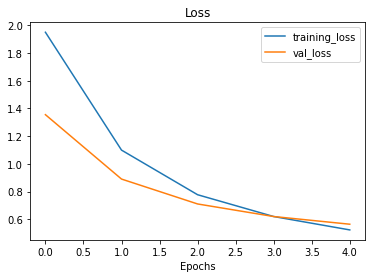

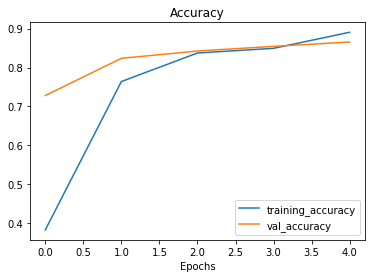

In [25]:
plot_loss_curves(efficientnet_history)

In [26]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different typer of transfer learning

## Different typer of transfer learning
* "As is" transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes)
* "Feature ectraction" transfer learning - use the prelearned pattern of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem
* "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (oncluding new output layers)

In [31]:
#How man layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Comparing our models results using TensorBoard

In [37]:
#Upload TensorBoard  dev records
#!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature ectraction model architectures" --one_shot

In [38]:
#Check out what TensorBoard experiments you have
#!tensorboard dev list